In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
import dask
import gc
import cartopy
import cartopy.crs as ccrs
import bottleneck
import haversine as hs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pygad
from multiprocessing import cpu_count
from os import sched_getaffinity
from collections import Counter
import csv
from collections import defaultdict
import collections
from global_land_mask import globe

In [2]:
n_cores = cpu_count()
print(f'Number of Logical CPU cores: {n_cores}')
n_available_cores = len(sched_getaffinity(0))
print(f'Number of Available CPU cores: {n_available_cores}')

Number of Logical CPU cores: 64
Number of Available CPU cores: 60


In [3]:
#importing dataset
paths = ['./data/netcdf/80m_full_file.nc']
ds = xr.open_mfdataset(paths, parallel=False,concat_dim='time', data_vars='minimal',combine='nested',
                       coords='minimal',compat='override').compute().load()
ds_mean = ds.mean(dim='time')['wind_mag'].transpose().compute().load() #finding averages
ds_distances = xr.open_mfdataset("./data/netcdf/UK_coast_distances.nc").compute()
ds_sum = ds.sum(dim='time')
paths = ['./data/depth_map.nc'] #importing depth dataset
ds_depth = xr.open_mfdataset(paths,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override').compute()

#implement a preloading of summed data for total figures

#grdpnt_power = 30*30*6
grdpnt_power = 13.5*27.5*6
turbine_rating = 0.9 #MW
n_turbs_grdpnt = grdpnt_power/turbine_rating
loss_factor = 1 #energy lost due to wind turbines in farms


#correlation function definition
def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True)) * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)
def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))
def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)
def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc,
        x,
        y,
        input_core_dims=[[dim], [dim]],
        dask="parallelized",
        output_dtypes=[float])

In [4]:
def open_wind_farm_csv(location):
    """Opens the wind farm csv and outputs a dictionary of locations."""
    columns = defaultdict(list) # each value in each column is appended to a list
    with open(location) as f:
        reader = csv.DictReader(f) # read rows into a dictionary format
        for row in reader: # read a row as {column1: value1, column2: value2,...}
            for (k,v) in row.items(): # go over each column name and value 
                columns[k].append(v) # append the value into the appropriate list
                                     # based on column name k
    coords = dict()
    coords['Latitude'] = np.array(list(map(float, columns['Latitude'][:19])))
    coords['Longitude'] = np.array(list(map(float, columns['Longitude'][:19])))
    return coords

def create_corr_dict():
    #creating correlation dictionary from all specified locations
    corr_dict = dict()
    spec_farm_lats = open_wind_farm_csv('./data/Wind_Farm_Locations.csv')["Latitude"]
    spec_farm_lons = open_wind_farm_csv('./data/Wind_Farm_Locations.csv')["Longitude"]
    spec_farm_lats = (np.round(spec_farm_lats*4, decimals=0)/4)
    spec_farm_lons = (np.round(spec_farm_lons*4, decimals=0)/4)
    n_spec_locs = spec_farm_lats.shape[0] #defining number of specific wind farm locations
    #cycle through wind farm locations to store correlations
    for i in range(n_spec_locs):
        for j in range(i+1):
            array1 = ds['power'].sel(latitude = spec_farm_lats[i], longitude = spec_farm_lons[i]).compute()
            array2 = ds['power'].sel(latitude = spec_farm_lats[j], longitude = spec_farm_lons[j]).compute()
            corr = spearman_correlation(array1, array2, 'time')
            del array1
            del array2
            corr_dict[spec_farm_lats[i],spec_farm_lons[i],spec_farm_lats[j],spec_farm_lons[j]] = corr
            corr_dict[spec_farm_lats[j],spec_farm_lons[j],spec_farm_lats[i],spec_farm_lons[i]] = corr
    
    return corr_dict

corr_dict = create_corr_dict()


def fitness_func_spec(coord_idx, solution_idx):
    """Fitness function to evaluate the validity of set of wind farm locations. Applyies various statistical 
    analyses to the wind speed dataset with repect to the input given. Evaluates the analysis and gives 
    contributing factors to the fitness function that it outputted.
    
    Inputs
    coord_idx: 1D array of latitudes in the first half and longitudes in the second half, each corresponding to 
    their respective pair in the ajdacent half
    Returns
    fitness: value from 0 to 1, 0 is the least 'fit' and 1 it the most 'fit'
    """
    
    coord_idx = coord_idx.astype('int')
    
    #convert indexes to locations
    spec_farm_lats = open_wind_farm_csv('./data/Wind_Farm_Locations.csv')["Latitude"]
    spec_farm_lons = open_wind_farm_csv('./data/Wind_Farm_Locations.csv')["Longitude"]
    spec_farm_lats = (np.round(spec_farm_lats*4, decimals=0)/4)
    spec_farm_lons = (np.round(spec_farm_lons*4, decimals=0)/4)
    lats = spec_farm_lats[coord_idx]
    lons = spec_farm_lons[coord_idx]
    coord_sol = np.hstack((lats,lons))

    
    num_farms = int(coord_sol.shape[0]/2) #set number of farms
    
    ##depth##
    #relies on preloaded depth dataset of values z > -60m and location space depths in this range aswell
    lats_init = xr.DataArray(spec_farm_lats[coord_idx], dims='coords')
    lons_init = xr.DataArray(spec_farm_lons[coord_idx], dims='coords') 
    farm_depths = ds_depth.sel(lat = lats_init, lon = lons_init,method="nearest", tolerance=0.1)
    farm_depth_arr = farm_depths.to_array().to_numpy()[0]
    depth_factor = np.sum(1 + farm_depth_arr/(60*3))/num_farms #comes from 50% increased cost at 60m below sea level, 
    #maximum of 1/3 penalty factor given due to depth
    
    
    #farm location init.
    
    lats = xr.DataArray(coord_sol[:num_farms], dims='coords')
    lons = xr.DataArray(coord_sol[num_farms:], dims='coords')
    onshore = globe.is_land(lats, lons)
    num_onshore_farms = onshore.sum().item() #number of onshore farm 
    agg_power = ((ds['power']
                     .sel(latitude = lats, longitude = lons)*n_turbs_grdpnt*loss_factor)
                     .sum(dim='coords')).compute()
    
    
    #capacity factor (time averaged power factor)
    total_capacity = 8000 * n_turbs_grdpnt * num_farms #kW
    capacity_factor = agg_power.mean().values/total_capacity
    
    #loss factor for offshore farms
    offshore = np.logical_not(onshore)
    farm_distances = ds_distances.sel(latitude = lats, longitude = lons)
    offshore_dists = farm_distances.where(offshore)
    offshore_dists_far = offshore_dists.where(offshore_dists > 50) #selecting all farms > 50km
    num_far_offshore_farms = offshore_dists_far.count().to_array().to_numpy()[0]
    offshore_cable_loss = (offshore_dists_far/1000)*0.035 #cable loss
    offshore_dists_close = offshore_dists.where(offshore_dists <= 50) #selecting all farms <= 50km
    num_close_offshore_farms = offshore_dists_close.count().to_array().to_numpy()[0]
    offshore_close_cable_loss = (offshore_dists_close*(0.025/50)) #cable loss
    offshore_loss_avg = 1 - ((offshore_cable_loss.sum().to_array().to_numpy()[0]+0.014*num_far_offshore_farms+
                                offshore_close_cable_loss.sum().to_array().to_numpy()[0])/(num_farms)) 
                                 #avg loss, converts to % and adds conversion loss
    
    #correlation init.
    combinations = int(num_farms*(num_farms-1)/2)
    ranks = xr.DataArray(np.zeros((combinations)))

    #firm capacity init.
    ratios = np.array([0.3,0.4,0.5])
    power_limit = ratios * 8000 * n_turbs_grdpnt * num_farms
    firm_capacity = np.empty((ratios.shape[0]))
    unavailable_prop = np.empty((ratios.shape[0]))
    arr_length = agg_power.shape[0]

    #unavailable init.
    num_yrs = 24 #years
    store = dict()
    store_hours = dict()
    storage_limit = 50 #GWh
    store_above_limit = dict()
    

    for i in range(power_limit.shape[0]):

#         ##unavailable##
#         store[i] = []
#         store_hours[i] = []
#         working_ds = agg_power.copy() - power_limit[i]  
#         working_ds = working_ds.where(working_ds < 0,0).values
#         count = 0 
#         num_hours = 0
#         #sums the groups
#         for j in working_ds:
#             if j.item() == 0:
#                 if count != 0:
#                     store[i].append(count)
#                     store_hours[i].append(num_hours)
#                     count = 0
#                     num_hours = 0
#             else:
#                 count += j.item()
#                 num_hours += 1
#         if count != 0:
#             store[i].append(count)
#             store_hours[i].append(num_hours)
#         store[i] = np.abs(np.array(store[i]))/1e6
#         store_hours[i] = np.sum(np.where(store[i] >= storage_limit,store_hours[i],0))
#         unavailable_prop[i] = store_hours[i]/(8760*24)


        ##firm capacity##
        working_ds = agg_power
        val = working_ds.where(working_ds>=power_limit[i]).count(dim='time').values
        firm_capacity[i] = val/arr_length #proportion of values above the power limit
        
    
    global corr_dict
    ##correlation##           
    count = 0    
    #sums the correlations between each of the 'solution' wind farms
    for i in range(num_farms):
        for j in range(i):        
            ranks[count] = corr_dict[coord_sol[i],coord_sol[num_farms+i],coord_sol[j],coord_sol[num_farms+j]]
            count += 1
    ranks = ranks.to_numpy()
    rank = (np.average(ranks)+1)/2 #0 to 1
    
    
    
    #better = larger
    fitness = ((1-rank) * np.average(firm_capacity) * 1.0**num_onshore_farms * offshore_loss_avg 
               * capacity_factor * depth_factor) # * (1 - np.average(unavailable_prop)))
    
    
    #print('Unavailable prop:',unavailable_prop[:]) #unavailable prop discarded - same measure as firm capacity
#     print('Firm capacity:',firm_capacity[:])
#     print('Avg. correlation:',rank)
#     print('Offshore loss:',offshore_loss_avg)
#     print('Capacity factor:',capacity_factor)
#     print('Depth factor:',depth_factor)
#     print('Fitness:',fitness)
    
    return fitness

In [5]:
fitness_function = fitness_func_spec

num_generations = 125
num_parents_mating = 2

sol_per_pop = 20 #num different groups that can be chosen (# chromosomes)
num_genes = 30 #num of farms per group (# genes per chromosome)

#create gene_space
gene_space=np.arange(0,open_wind_farm_csv('./data/Wind_Farm_Locations.csv')["Latitude"].shape[0],dtype='int')

parent_selection_type = "rank"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "adaptive"
mutation_percent_genes = [30,10]

def callback_gen(ga_instance):
    print("Generation : ", ga_instance.generations_completed)
    print("Fitness of the best solution :", ga_instance.best_solution()[1])

last_fitness = 0
start_step = time.time()
def on_generation(ga_instance):
    global last_fitness
    global start_step
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness))
    end = time.time()
    print('Time taken:',np.round(end-start_step,decimals=3),'secs \n')
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]
    start_step = time.time()

In [ ]:
num_repeats = 33
for i in range(num_repeats):
    
    #intialising
    ga_instance = pygad.GA(num_generations=num_generations,
                       gene_space = gene_space,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=on_generation,
                       parallel_processing=["process",sol_per_pop])
    
    start = time.time()
    ga_instance.run() #runnning optimisation
    end = time.time()
    print('Time taken:',np.round(end-start,decimals=3), 'Step:',i)
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    np.savetxt(f'./data/farm_locations/locs_specd_final{i}',solution)

Generation = 1
Fitness    = 0.08231157663579551
Change     = 0.08231157663579551
Time taken: 18.574 secs 

Generation = 2
Fitness    = 0.08405291627235144
Change     = 0.0017413396365559275
Time taken: 15.032 secs 

Generation = 3
Fitness    = 0.08932199297935596
Change     = 0.005269076707004522
Time taken: 13.237 secs 

Generation = 4
Fitness    = 0.08955679618871151
Change     = 0.00023480320935555243
Time taken: 14.387 secs 

Generation = 5
Fitness    = 0.08955679618871151
Change     = 0.0
Time taken: 14.188 secs 

Generation = 6
Fitness    = 0.08985236291075732
Change     = 0.00029556672204580914
Time taken: 13.993 secs 

Generation = 7
Fitness    = 0.09108307059239719
Change     = 0.001230707681639867
Time taken: 14.066 secs 

Generation = 8
Fitness    = 0.09419257503642853
Change     = 0.0031095044440313385
Time taken: 13.738 secs 

Generation = 9
Fitness    = 0.09419257503642853
Change     = 0.0
Time taken: 12.53 secs 

Generation = 10
Fitness    = 0.09608664010517594
Change   

Generation = 87
Fitness    = 0.10126857329112501
Change     = 0.0
Time taken: 15.684 secs 

Generation = 88
Fitness    = 0.10126857329112501
Change     = 0.0
Time taken: 11.989 secs 

Generation = 89
Fitness    = 0.10126857329112501
Change     = 0.0
Time taken: 16.325 secs 

Generation = 90
Fitness    = 0.10126857329112501
Change     = 0.0
Time taken: 14.955 secs 

Generation = 91
Fitness    = 0.10126857329112501
Change     = 0.0
Time taken: 13.764 secs 

Generation = 92
Fitness    = 0.10126857329112501
Change     = 0.0
Time taken: 13.769 secs 

Generation = 93
Fitness    = 0.10126857329112501
Change     = 0.0
Time taken: 14.539 secs 

Generation = 94
Fitness    = 0.10126857329112501
Change     = 0.0
Time taken: 14.273 secs 

Generation = 95
Fitness    = 0.10126857329112501
Change     = 0.0
Time taken: 14.519 secs 

Generation = 96
Fitness    = 0.10126857329112501
Change     = 0.0
Time taken: 13.408 secs 

Generation = 97
Fitness    = 0.10126857329112501
Change     = 0.0
Time taken: 14

Generation = 47
Fitness    = 0.10058357786949032
Change     = 0.0
Time taken: 15.139 secs 

Generation = 48
Fitness    = 0.10058357786949032
Change     = 0.0
Time taken: 12.865 secs 

Generation = 49
Fitness    = 0.10058357786949032
Change     = 0.0
Time taken: 14.161 secs 

Generation = 50
Fitness    = 0.10058357786949032
Change     = 0.0
Time taken: 15.598 secs 

Generation = 51
Fitness    = 0.10058357786949032
Change     = 0.0
Time taken: 14.292 secs 

Generation = 52
Fitness    = 0.10058357786949032
Change     = 0.0
Time taken: 13.54 secs 

Generation = 53
Fitness    = 0.10058357786949032
Change     = 0.0
Time taken: 12.19 secs 

Generation = 54
Fitness    = 0.10058357786949032
Change     = 0.0
Time taken: 13.322 secs 

Generation = 55
Fitness    = 0.10058357786949032
Change     = 0.0
Time taken: 12.691 secs 

Generation = 56
Fitness    = 0.10058357786949032
Change     = 0.0
Time taken: 12.25 secs 

Generation = 57
Fitness    = 0.10058357786949032
Change     = 0.0
Time taken: 12.21

Generation = 9
Fitness    = 0.09416450587358528
Change     = 0.0
Time taken: 14.576 secs 

Generation = 10
Fitness    = 0.09457651159827202
Change     = 0.00041200572468673424
Time taken: 12.716 secs 

Generation = 11
Fitness    = 0.09609744747461742
Change     = 0.0015209358763454
Time taken: 14.358 secs 

Generation = 12
Fitness    = 0.0966268465484914
Change     = 0.0005293990738739762
Time taken: 14.546 secs 

Generation = 13
Fitness    = 0.0966268465484914
Change     = 0.0
Time taken: 13.242 secs 

Generation = 14
Fitness    = 0.0966268465484914
Change     = 0.0
Time taken: 14.617 secs 

Generation = 15
Fitness    = 0.09681523744509839
Change     = 0.0001883908966069936
Time taken: 13.113 secs 

Generation = 16
Fitness    = 0.09681523744509839
Change     = 0.0
Time taken: 14.901 secs 

Generation = 17
Fitness    = 0.09704080514918197
Change     = 0.00022556770408357907
Time taken: 14.565 secs 

Generation = 18
Fitness    = 0.09704080514918197
Change     = 0.0
Time taken: 13.755 se

Generation = 96
Fitness    = 0.10100431868003218
Change     = 0.0
Time taken: 15.741 secs 

Generation = 97
Fitness    = 0.10100431868003218
Change     = 0.0
Time taken: 14.34 secs 

Generation = 98
Fitness    = 0.10100431868003218
Change     = 0.0
Time taken: 12.939 secs 

Generation = 99
Fitness    = 0.10100431868003218
Change     = 0.0
Time taken: 14.242 secs 

Generation = 100
Fitness    = 0.10100431868003218
Change     = 0.0
Time taken: 14.409 secs 

Generation = 101
Fitness    = 0.10107636107553947
Change     = 7.204239550728797e-05
Time taken: 13.362 secs 

Generation = 102
Fitness    = 0.10107636107553947
Change     = 0.0
Time taken: 12.514 secs 

Generation = 103
Fitness    = 0.10107636107553947
Change     = 0.0
Time taken: 14.496 secs 

Generation = 104
Fitness    = 0.10107636107553947
Change     = 0.0
Time taken: 14.252 secs 

Generation = 105
Fitness    = 0.10107636107553947
Change     = 0.0
Time taken: 14.287 secs 

Generation = 106
Fitness    = 0.10107636107553947
Change 

Generation = 56
Fitness    = 0.10090501776156599
Change     = 0.0
Time taken: 14.353 secs 

Generation = 57
Fitness    = 0.10090501776156599
Change     = 0.0
Time taken: 13.153 secs 

Generation = 58
Fitness    = 0.10090501776156599
Change     = 0.0
Time taken: 13.963 secs 

Generation = 59
Fitness    = 0.10090501776156599
Change     = 0.0
Time taken: 13.822 secs 

Generation = 60
Fitness    = 0.10090501776156599
Change     = 0.0
Time taken: 14.723 secs 

Generation = 61
Fitness    = 0.10090501776156599
Change     = 0.0
Time taken: 15.346 secs 

Generation = 62
Fitness    = 0.10090501776156599
Change     = 0.0
Time taken: 14.751 secs 

Generation = 63
Fitness    = 0.10090501776156599
Change     = 0.0
Time taken: 12.594 secs 

Generation = 64
Fitness    = 0.10106996882392374
Change     = 0.00016495106235775436
Time taken: 12.546 secs 

Generation = 65
Fitness    = 0.10106996882392374
Change     = 0.0
Time taken: 13.922 secs 

Generation = 66
Fitness    = 0.10106996882392374
Change     =

Generation = 17
Fitness    = 0.0990603111071501
Change     = 0.0004994652655856691
Time taken: 13.907 secs 

Generation = 18
Fitness    = 0.09931104946980417
Change     = 0.0002507383626540599
Time taken: 12.892 secs 

Generation = 19
Fitness    = 0.09936811305598615
Change     = 5.7063586181987924e-05
Time taken: 14.421 secs 

Generation = 20
Fitness    = 0.09936811305598615
Change     = 0.0
Time taken: 14.91 secs 

Generation = 21
Fitness    = 0.09936811305598615
Change     = 0.0
Time taken: 12.351 secs 

Generation = 22
Fitness    = 0.09936811305598615
Change     = 0.0
Time taken: 11.952 secs 

Generation = 23
Fitness    = 0.09944297101226608
Change     = 7.485795627992786e-05
Time taken: 15.735 secs 

Generation = 24
Fitness    = 0.09944297101226608
Change     = 0.0
Time taken: 14.179 secs 

Generation = 25
Fitness    = 0.1002420091725128
Change     = 0.0007990381602467206
Time taken: 11.915 secs 

Generation = 26
Fitness    = 0.1002420091725128
Change     = 0.0
Time taken: 15.649 

Generation = 105
Fitness    = 0.10150326589875001
Change     = 0.0
Time taken: 12.909 secs 

Generation = 106
Fitness    = 0.10150326589875001
Change     = 0.0
Time taken: 12.351 secs 

Generation = 107
Fitness    = 0.10150326589875001
Change     = 0.0
Time taken: 14.768 secs 

Generation = 108
Fitness    = 0.10150326589875001
Change     = 0.0
Time taken: 13.139 secs 

Generation = 109
Fitness    = 0.10150326589875001
Change     = 0.0
Time taken: 15.12 secs 

Generation = 110
Fitness    = 0.10150326589875001
Change     = 0.0
Time taken: 13.135 secs 

Generation = 111
Fitness    = 0.10150326589875001
Change     = 0.0
Time taken: 13.921 secs 

Generation = 112
Fitness    = 0.10150326589875001
Change     = 0.0
Time taken: 13.26 secs 

Generation = 113
Fitness    = 0.10150326589875001
Change     = 0.0
Time taken: 14.538 secs 

Generation = 114
Fitness    = 0.10150326589875001
Change     = 0.0
Time taken: 14.266 secs 

Generation = 115
Fitness    = 0.10150326589875001
Change     = 0.0
Time 

Generation = 66
Fitness    = 0.10132397816222982
Change     = 0.0
Time taken: 15.602 secs 

Generation = 67
Fitness    = 0.10132397816222982
Change     = 0.0
Time taken: 14.623 secs 

Generation = 68
Fitness    = 0.10132397816222982
Change     = 0.0
Time taken: 13.996 secs 

Generation = 69
Fitness    = 0.10132397816222982
Change     = 0.0
Time taken: 13.617 secs 

Generation = 70
Fitness    = 0.10132397816222982
Change     = 0.0
Time taken: 14.754 secs 

Generation = 71
Fitness    = 0.10132397816222982
Change     = 0.0
Time taken: 13.929 secs 

Generation = 72
Fitness    = 0.10132397816222982
Change     = 0.0
Time taken: 13.178 secs 

Generation = 73
Fitness    = 0.10132397816222982
Change     = 0.0
Time taken: 12.45 secs 

Generation = 74
Fitness    = 0.10132397816222982
Change     = 0.0
Time taken: 15.544 secs 

Generation = 75
Fitness    = 0.10147623267471056
Change     = 0.00015225451248074284
Time taken: 11.936 secs 

Generation = 76
Fitness    = 0.10147623267471056
Change     = 

Generation = 27
Fitness    = 0.09847980869530908
Change     = 0.0
Time taken: 13.964 secs 

Generation = 28
Fitness    = 0.09904201259464726
Change     = 0.0005622038993381845
Time taken: 13.678 secs 

Generation = 29
Fitness    = 0.09904201259464726
Change     = 0.0
Time taken: 11.742 secs 

Generation = 30
Fitness    = 0.09904201259464726
Change     = 0.0
Time taken: 14.122 secs 

Generation = 31
Fitness    = 0.09910737335732883
Change     = 6.53607626815711e-05
Time taken: 11.429 secs 

Generation = 32
Fitness    = 0.09910737335732883
Change     = 0.0
Time taken: 14.007 secs 

Generation = 33
Fitness    = 0.09910737335732883
Change     = 0.0
Time taken: 12.186 secs 

Generation = 34
Fitness    = 0.09910737335732883
Change     = 0.0
Time taken: 11.62 secs 

Generation = 35
Fitness    = 0.09910737335732883
Change     = 0.0
Time taken: 12.212 secs 

Generation = 36
Fitness    = 0.09910737335732883
Change     = 0.0
Time taken: 13.143 secs 

Generation = 37
Fitness    = 0.099107373357328

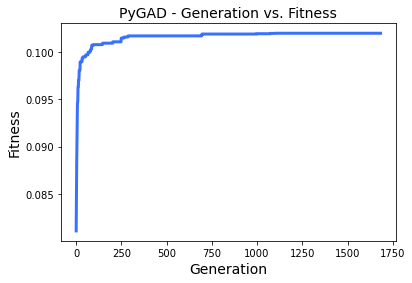

Figure(432x288)


In [27]:
print(ga_instance.plot_fitness())